In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

In [ ]:
# load dữ liệu
x_train = np.load('/content/drive/MyDrive/AI/CNN_Competition/data/X_train.npy')
y_train = np.load('/content/drive/MyDrive/AI/CNN_Competition/data/y_train.npy')

# chia data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


#Image - Pre-processing

- ## Data agument

In [ ]:
def random_rotate_vector(image):
    # Góc xoay ngẫu nhiên
    angle = np.random.uniform(10, 20) if np.random.randint(0, 2) == 0 else np.random.uniform(-10, -20)

    # Tính toán ma trận xoay và góc xoay
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    # Thực hiện xoay ảnh
    rotated_img = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    return rotated_img.flatten()

In [ ]:
# half_trainset = len(x_train) // 2
# data_agument = np.array([random_rotate_vector(image.reshape(28, 28)) for image in x_train[:half_trainset]])
# x_train = np.concatenate((x_train, data_agument), axis=0)
# y_train = np.concatenate((y_train, y_train[:half_trainset]), axis=0)

# print(x_train.shape)
# print(y_train.shape)

- ## Draw some image



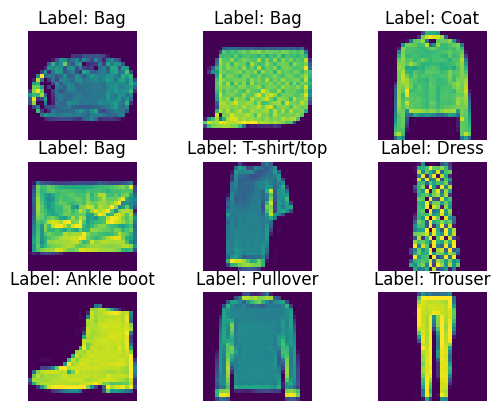

In [ ]:
def show_random_images(x, y):
    import random
    LABEL_DICT = {
     0: "T-shirt/top",
     1: "Trouser",
     2: "Pullover",
     3: "Dress",
     4: "Coat",
     5: "Sandal",
     6: "Shirt",
     7: "Sneaker",
     8: "Bag",
     9: "Ankle boot"
    }

    random_indices = np.random.choice(len(x), 9, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[idx].reshape(28, 28))
        plt.title(f"Label: {LABEL_DICT[y[idx]]}")
        plt.axis('off')
    plt.show()

show_random_images(x_val, y_val)

- ## Normalization

In [ ]:
from tensorflow.keras.utils import to_categorical
# chuyển label thành 1 vector one hot
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
print(y_train.shape)
print(y_val.shape)

(33600, 10)
(8400, 10)


# Convolutional Neural Network (CNN) Architecture

In [ ]:
from tensorflow.keras.applications import EfficientNetV2M

In [ ]:
input_shape = (224, 224, 3)

num_classes = 10

base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [ ]:
print(len(base_model.layers))

740


In [ ]:
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(8400, 784)
(8400, 10)
(33600, 784)
(33600, 10)


In [ ]:
def preprocess_image(image, label):
    image = tf.expand_dims(tf.reshape(image, (28, 28)) , axis=-1)
    image = tf.image.resize(image, input_shape[:2])
    image = tf.concat([image] * 3, axis=-1)
    return image, label

batch_size = 32
# Create the train dataset with TensorFlow transformations
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create the validation dataset with TensorFlow transformations
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# prompt: print train_dataset and val_dataset info

print(train_dataset)
print(val_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [ ]:
def create_model(base_model):
  input_image = layers.Input(shape=input_shape)

  pre_model = base_model(input_image)

  x = layers.GlobalAveragePooling2D()(pre_model)
  # x = layers.Dense(1024, activation='relu')(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.Dense(512, activation='relu')(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.Dense(128, activation='relu')(x)
  # x = layers.Dropout(0.15)(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.Dense(64, activation='relu')(x)
  # x = layers.Dropout(0.3)(x)
  # x = layers.BatchNormalization()(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  model = keras.Model(inputs=input_image, outputs=outputs, name='model')

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='RMSprop', metrics=['accuracy'])

  return model

In [ ]:
model = create_model(base_model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-m (Function  (None, 7, 7, 1280)        53150388  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 53163198 (202.80 MB)
Trainable params: 52871166 (201.69 MB)
Non-trainable params: 292032 (1.11 MB)
_________________________________________________________________


In [ ]:
filepath="/content/drive/MyDrive/AI/CNN_Competition/weights/"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

his = model.fit(train_dataset, validation_data=val_dataset, batch_size=batch_size, epochs=50, callbacks=[callbacks_list], shuffle=True)

Epoch 1/50
1050/1050 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8617
Epoch 1: val_accuracy improved from -inf to 0.91119, saving model to /content/drive/MyDrive/AI/CNN_Competition/weights/
1050/1050 [==============================] - 615s 482ms/step - loss: 0.3895 - accuracy: 0.8617 - val_loss: 0.2530 - val_accuracy: 0.9112
Epoch 2/50
1050/1050 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9221
Epoch 2: val_accuracy improved from 0.91119 to 0.92036, saving model to /content/drive/MyDrive/AI/CNN_Competition/weights/
1050/1050 [==============================] - 487s 464ms/step - loss: 0.2174 - accuracy: 0.9221 - val_loss: 0.2371 - val_accuracy: 0.9204
Epoch 3/50
1050/1050 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9384
Epoch 3: val_accuracy improved from 0.92036 to 0.92833, saving model to /content/drive/MyDrive/AI/CNN_Competition/weights/
1050/1050 [==============================] - 487s 463ms/step - los

In [3]:
# load predict model
model = tf.keras.models.load_model('/content/drive/MyDrive/AI/CNN_Competition/weights/')

In [4]:
input_shape = (224, 224, 3)
def preprocess_image_for_prediction(image):
    # Preprocessing steps without labels
    image = tf.expand_dims(tf.reshape(image, (28, 28)), axis=-1)
    image = tf.image.resize(image, input_shape[:2])
    image = tf.concat([image] * 3, axis=-1)
    return image

In [5]:
# dự đoán kết quả sau đó xuất ra csv
x_test = np.load('/content/drive/MyDrive/AI/CNN_Competition/data/X_test.npy')

test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.map(preprocess_image_for_prediction, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)

predictions = model.predict(test_dataset)
predicted_labels = predictions.argmax(axis=1)
results = pd.DataFrame({
    'index': range(len(x_test)),
    'label': predicted_labels
})
results.to_csv('/content/drive/MyDrive/AI/CNN_Competition/Latest_submission.csv', index=False)

875/875 [==============================] - 185s 196ms/step
